# Pregunta 1

Importamos las librerías necesarias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma

$$\frac{\det(X)^{(k-p-1)/2}}{2^{kp/2}}$$

$$z_i = L z_0$$

$$X = \sum_{i=0}^k z_i z_i^\top = L z_0 z_0^\top L^\top$$

Definimos funciones.

In [2]:
def gen_X(n, V):
    X = np.zeros_like(V)
    for _ in range(n):
        z0 = np.random.normal(0,1,(V.shape[0],1)) 
        X += z0 @ z0.T
    L = np.linalg.cholesky(V)
    return L @ X @ L.T

def gamma_p(p, x):
    prod = 1
    for j in range(1,p+1):
        prod *= gamma(x-(j-1)/2)
    return np.pi**(p*(p-1)/4) * prod

def f(X, k, V):
    p = X.shape[0]
    dets = np.linalg.det(X)**((k-p-1)/2)/np.linalg.det(V)**(k/2) if p>1 else float(X)**((k-p-1)/2)/float(V)**(k/2)
    exp  = np.exp(-0.5*np.trace(np.linalg.inv(V)@X)) if p>1 else np.exp(-0.5*float(X)/float(V)) 
    return dets * exp / (2**(k*p/2) * gamma_p(p, k/2))

In [3]:
p = 1
V = np.eye(p) #np.diag(np.random.uniform(0,1,p))
n = p+6

In [4]:
%%time
X = gen_X(n, V)

CPU times: total: 0 ns
Wall time: 0 ns


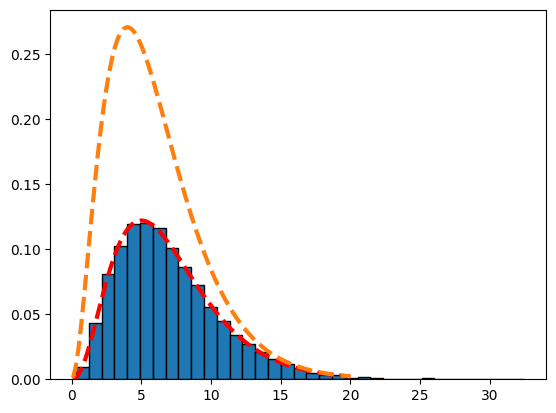

In [5]:
x = np.linspace(0.1,20,100)
plt.hist([float(gen_X(n,V)) for _ in range(10_000)], density=True, bins=35, edgecolor='k')
plt.plot(x, [f(np.array([xx]),n,V) for xx in x], lw=3, ls='--', c='r');
plt.plot(x, [2*f(np.array([xx]),n-1,V) for xx in x], lw=3, ls='--');

In [6]:
def buscar_M(k, V):
    M = 1
    cont = 0
    while cont<1_000:
        X = gen_X(int(k), V)
        if f(X,k,V)/(M*f(X,int(k),V)) > 1:
            cont = 0
            M += 0.1
        cont += 1
    return M

In [7]:
def MH_indep(k,V,N=1_000):
    '''
    Implementación del algoritmo Metropolis-Hastings independiente
    '''
    L = [gen_X(int(k), V)]
    for _ in range(N-1):
        y = gen_X(int(k), V)
        u = np.random.uniform()
        a = 0 if f(L[-1], k, V)*f(y, int(k), V) == 0 else min(1, f(y,k,V)*f(L[-1],int(k),V) / (f(L[-1],k,V)*f(y,int(k),V)))
        L.append(y) if u < a else L.append(L[-1])
    return L

In [8]:
def accept_reject(n_examples, k, V, M):
    n, rechazados, aceptados = 0, 0, []
    while n<n_examples:
        X = gen_X(int(k), V)
        if np.random.uniform() <= f(X,k,V)/(M*f(X,int(k),V)):
            aceptados.append(X)
            n+=1
        else:
            rechazados+=1
    return aceptados, rechazados

In [20]:
p = 12
V = np.diag(np.random.uniform(0,1,p))
n_examples, k = 1_000, p+1+np.random.uniform()
M = buscar_M(k, V)
aceptados, rechazados = accept_reject(n_examples, k, V, M)

In [21]:
1/M

0.15873015873015886

In [22]:
n_examples / (n_examples+rechazados)

0.16294606485253382

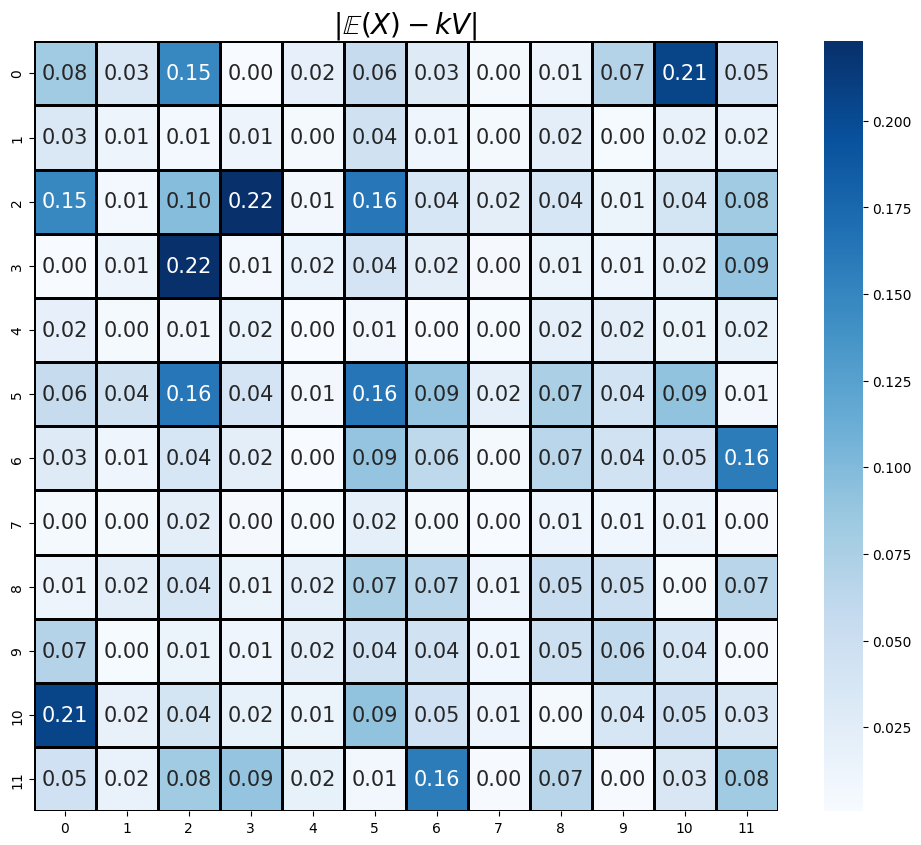

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(abs(np.mean(aceptados,axis=0)-k*V), annot=True, cmap="Blues",
            annot_kws={"size":15}, fmt=".2f",#, vmin=0, vmax=k*V.max()/2,
            linecolor='k', linewidths=1
            )
plt.title(r'$|\mathbb{E}(X)-kV|$', size = 20);

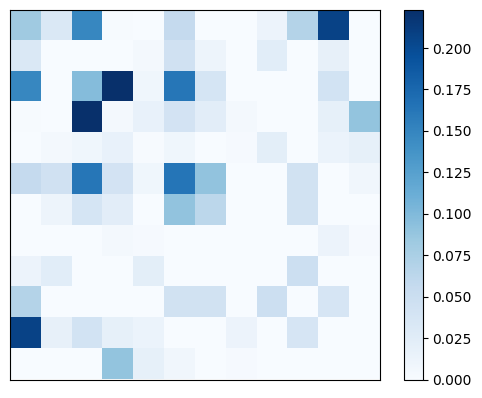

In [24]:
plt.imshow(np.mean(aceptados,axis=0)-k*V, cmap='Blues', vmin=0)
plt.colorbar()
plt.xticks([]);plt.yticks([]);

In [25]:
np.linalg.norm(np.mean(aceptados,axis=0)-k*V)

0.7490515765316709

# CON METROPOLIS - HASTINGS

In [26]:
L = MH_indep(k, V)

In [27]:
len(L)

1000

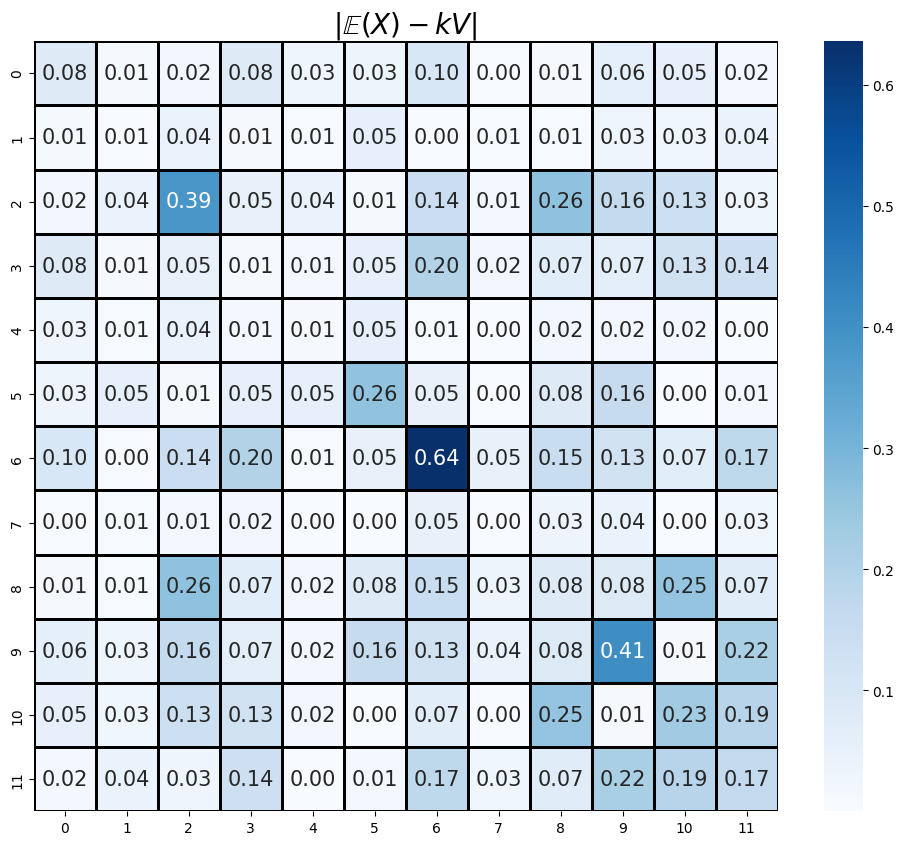

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(abs(np.mean(L,axis=0)-k*V), annot=True, cmap="Blues",
            annot_kws={"size":15}, fmt=".2f", # vmin=0, vmax=k*V.max()/2,
            linecolor='k', linewidths=1
            )
plt.title(r'$|\mathbb{E}(X)-kV|$', size = 20);

In [29]:
np.linalg.norm(np.mean(L,axis=0)-k*V)

1.4009536863202536